# Laboratorium 3

### Konfiguracja

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


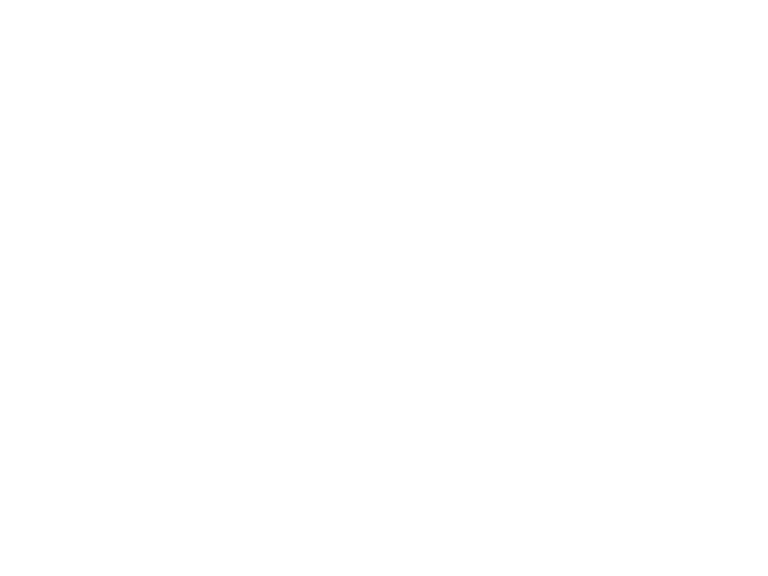

In [4]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


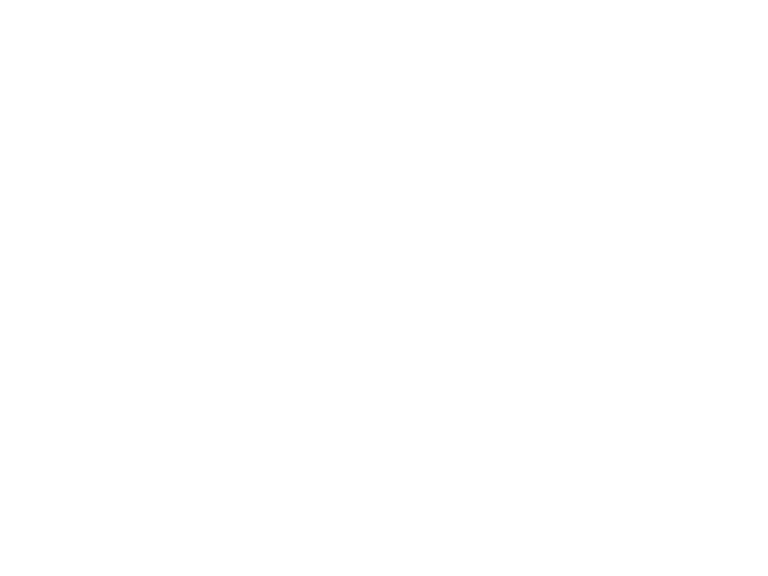

In [5]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

In [50]:
X = 0


##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [51]:

class Point:
    def __init__(self, coord, isLeft=False, isInter=False): ## coord : tuple(x, y), isLeft: boolean value if point
                                            ## is the beginning or the end of the line 
        self.isLeft = isLeft
        self.coord = coord
        self.isInter = isInter
        self.line = None
        self.key = coord[1]
        
    def add_other(self, other):
        self.other = other
    
    def calc_line(self):
        pa, pb = self.coord, self.other.coord
        a1 = (pb[1] - pa[1])/ (pb[0] - pa[0])
        b1 = pa[1] - a1*pa[0]
        return a1, b1
    
    def get_line(self):
        if not self.isLeft:
            raise Exception("this is not left line point!")
        if self.line is None:
            self.line = self.calc_line()
        return self.line
    
    def recalc_key(self, x):
        a, b = self.get_line()
        self.key = a*x + b
        
    def add_inters_points(self, point1, point2):  # 1st points of lines that intersect 
        self.collidingLine1 = point1
        self.collidingLine2 = point2
        
    def __lt__(self, other):
        print("calc at x", X)
        if self.isInter:
            raise Exception("not a line!")
        lineA = self.get_line()
        lineB = other.get_line()
        return lineA[0]*X + lineA[1] < lineB[0]*X + lineB[1]
        
    def __eq__(self, other): 
        return self.coord == other.coord
    def __str__(self):
        return str(f'({self.coord}) key {self.key} ')
    def __repr__(self):
        return str(self.coord)
    def __hash__(self):
        return hash(self.coord)

In [30]:
def line_factory(coord1, coord2):
    p1 = Point( coord1, isLeft=True)
    p2 = Point( coord2)    
    p1.add_other(p2)
    p2.add_other(p1)
    return p1, p2

In [31]:
def intersect( startPt1, startPt2): # returns points of intersection or None
    a1, b1 = startPt1.get_line()
    a2, b2 = startPt2.get_line()
    W = a2 - a1
    if W == 0:
        return None  # parralel 
    W1 = b1 - b2
    W2 = b1*a2 - a1*b2
    x, y = W1/W, W2/W  
    # check if not outside segments 
    if x < min(startPt1.other.coord[0], startPt2.other.coord[0]) and \
        x >max(startPt1.coord[0], startPt2.coord[0]):
        interPt = Point( (x, y), isLeft=False, isInter=True )
        interPt.add_inters_points(startPt1, startPt2)
        return interPt
    return None 
    
# tests
pa = Point((0, 0), True, False)
pb = Point((2, 2))
pa.add_other(pb)

pc = Point((-3, 1), True, False)
pd = Point((5, 2))
pc.add_other(pd)

print(intersect(pa, pc))

((1.5714285714285714, 1.5714285714285714)) key 1.5714285714285714 


In [10]:
def pointsToLineCoord(points):
    ordinLines = []
    for point in points:
        line = [point.coord, point.other.coord]
        ordinLines.append(line)
    return ordinLines

<IPython.core.display.Javascript object>


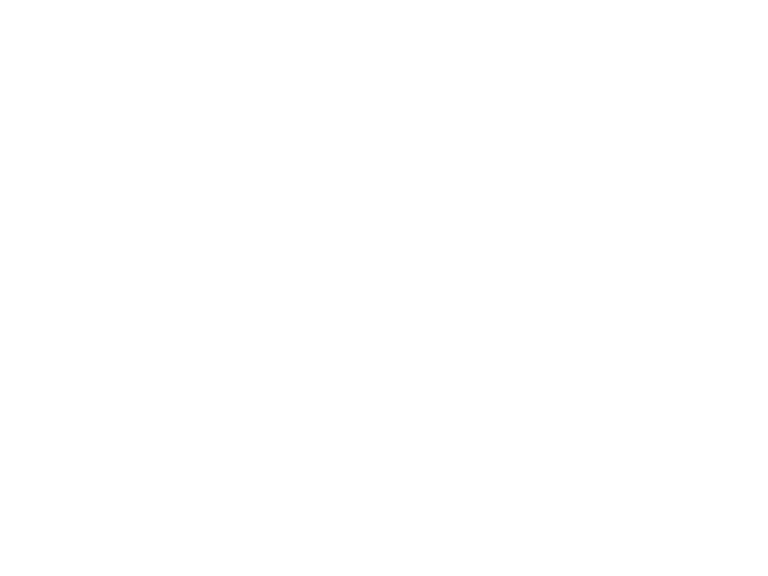

In [11]:
#Dodaj tu punkty i/lub odcinki
plot1 = Plot()
plot1.draw()

0 0


<IPython.core.display.Javascript object>


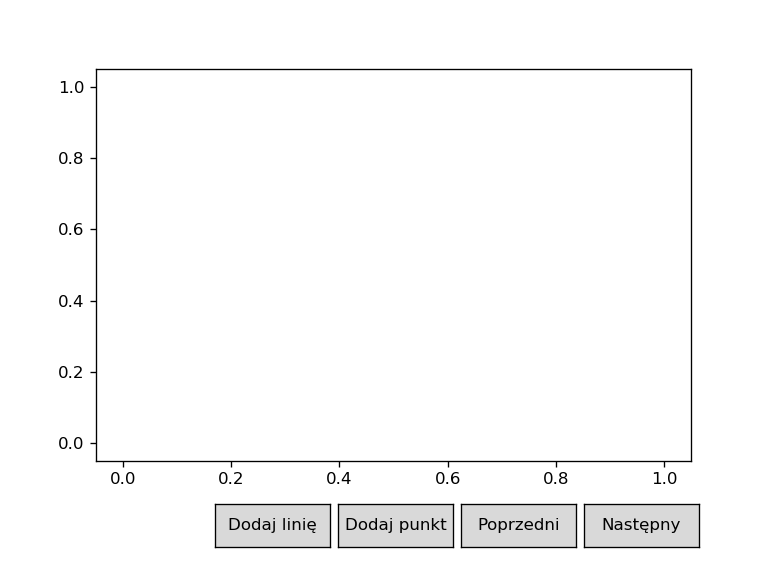

In [32]:
""" execute to add last added lines """
myLines = []  # list of added points
plot2 = Plot([plot1.get_added_elements()])
linCols = plot1.get_added_lines()  # list of collections of lines 
ptsCols = plot1.get_added_points()  # list of collections of points
print(len(linCols), len(ptsCols))
for linCol in linCols:
    for line in linCol.lines:
        if line[0][0] == line[1][0]:
            continue;
        if line[0][0] > line[1][0]:
            line[0], line [1] = line[1], line[0] 
#         pa = Point((line[0][0], line[0][1]), isLeft=True)
#         pb = Point((line[1][0], line[1][1]))
#         pa.add_other(pb)
#         pb.add_other(pa)
        pa, pb = line_factory((line[0][0], line[0][1]), (line[1][0], line[1][1]))
        myLines.append(pa)
        
plot2.draw()

### Rozwiązanie

In [13]:
%matplotlib notebook
import random
def generateRandomLines(nr, lowerLeft, upperRight):
    lines = []
    for i in range(0, nr):
        x1 = 0
        x2 = 0
        while(x1 == x2):
            x1 = random.uniform(lowerLeft[0], upperRight[0])
            x2 = random.uniform(lowerLeft[0], upperRight[0])
        y1 = random.uniform(lowerLeft[1], upperRight[1])
        y2 = random.uniform(lowerLeft[1], upperRight[1])
        if x1 > x2:
            x1, x2 = x2, x1
        p1, p2 = line_factory((x1, y1), (x2, y2))
        lines.append(p1)
        lines.append(p2)
    return lines
    


In [14]:
def recalculate_keys(T, x):
    newVals = []
    for val in T:
        val.recalc_key(x)
        newVals.append(val)
    return SortedSet(newVals, key=lambda p: p.key)
    

In [ ]:
def get_point_orientation_relative_to_line(point, line):
    keyA =  
    def recalc_key(self, x):
        a, b = self.get_line()
        self.key = a*x + b
    start = line.start
    end = line.end
    if point == start or point == end:
        return EQUAL

    result = start.x * end.y + end.x * point.y + point.x * start.y - end.x * start.y - start.x * point.y - point.x * end.y
    sign = -1 if result < 0 else 1
    result = math.fabs(result)

    if result > EPS:
        if sign == 1:
            return ABOVE

        else:
            return BELOW
    return EQUAL

In [53]:
%matplotlib notebook
from sortedcontainers import SortedSet
a1, a2 =line_factory((1,4), (4,3))
a3, a4 =line_factory((3,5), (6,5))
a5, a6 = line_factory((2,3), (4,4))
a7, a8 = line_factory((3.5,3.5), (4,6))

pts = [a1, a2, a3, a4, a5, a6, a7, a8]
# pts = generateRandomLines(10, (0,0), (4,4))
def get_neighs(T, ind):
    neighs = []
    if ind > 0:
        neighs.append(T[ind-1])
    if ind < len(T)-1:
        neighs.append(T[ind+1])
    return neighs

def sweeping(points):  # lines - list of pairs of tuples (x1, y1) (x2, y2) where x1 < x2
#     T # contains all active line segments ordered by y
    T = SortedSet([], key=lambda p: p.key)
#     event structure, contains all line points and intersections
    Q = SortedSet(points, key=lambda p: p.coord)
    print(Q)
    while(len(Q)>0):
        currPt = Q.pop(0)
        print(" x = ", currPt.coord[0])
        if(currPt.isLeft):  # beginning of segment
            print("adding line")
            T = recalculate_keys(T, currPt.coord[0])
            T.add( currPt)
            neighs = get_neighs(T, T.index(currPt)) # check intersections w neighbors
            for neigh in neighs:
                interPt = intersect(currPt, neigh)
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print(" new intersection ---------")
                    Q.add(interPt)
            
        elif(not currPt.isLeft and not currPt.isInter):  # end of segment
            print("deleting line")
            T = recalculate_keys(T, currPt.coord[0])
            neighs = get_neighs(T, T.index(currPt.other))
            if len(neighs)==2:
                interPt = intersect(neighs[0], neighs[1])
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print("  new intersection -----------")
                    Q.add(interPt)
            T.remove(currPt.other)
            
        else:  # intersection
            print("at intersection, point ", currPt )
            line1, line2 = currPt.collidingLine1, currPt.collidingLine2
            print(line1, line2)
            if line1.key > line2.key:
                line1, line2 = line2, line1
            neighs1 = get_neighs(T, T.index(line1))  # line2 and maybe sth
            neighs2 = get_neighs(T, T.index(line2))  # maybe sth and line1
            print(neighs1, neighs2)
            if len(neighs1) == 2:
                print("lower neigh exist", neighs1[0], neighs1[1])
                interPt = intersect(neighs1[0], neighs1[1])
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print(" new intersection ---------")
                    Q.add(interPt)
            if len(neighs2) == 2:
                print("upper neigh exist", neighs2[0], neighs2[1])
                interPt = intersect(neighs2[0], neighs2[1])
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print(" new intersection ----------")
                    Q.add(interPt)
            T = recalculate_keys(T, currPt.coord[0]+0.0001)
            # check intersection of line1 with line2 prev upper neigh
            # check intersection of line2 with line1 prev lower neigh
            
            
sweeping(pts)

SortedSet([(1, 4), (2, 3), (3, 5), (3.5, 3.5), (4, 3), (4, 4), (4, 6), (6, 5)], key=<function sweeping.<locals>.<lambda> at 0x0000026C1EDD7598>)
 x =  1
adding line
 x =  2
adding line
 new intersection ---------
 x =  2.8
at intersection, point  ((2.8, 3.4)) key 3.4 
((2, 3)) key 3  ((1, 4)) key 3.6666666666666665 
[(1, 4)] [(2, 3)]
 x =  3
adding line
 x =  3.5
adding line
 new intersection ---------
 x =  3.5555555555555554
at intersection, point  ((3.5555555555555554, 3.7777777777777777)) key 3.7777777777777777 
((3.5, 3.5)) key 3.5  ((2, 3)) key 3.75 
[(1, 4), (2, 3)] [(3.5, 3.5), (3, 5)]
lower neigh exist ((1, 4)) key 3.1666666666666665  ((2, 3)) key 3.75 
upper neigh exist ((3.5, 3.5)) key 3.5  ((3, 5)) key 5.0 
 new intersection ----------
 x =  3.8
at intersection, point  ((3.8, 5.0)) key 5.0 
((3.5, 3.5)) key 3.7782777777777774  ((3, 5)) key 5.0 
[(2, 3), (3, 5)] [(3.5, 3.5)]
lower neigh exist ((2, 3)) key 3.7778277777777776  ((3, 5)) key 5.0 
 x =  4
deleting line
 x =  4
de

In [ ]:
# visualization
%matplotlib notebook
from sortedcontainers import SortedSet
a1, a2 =line_factory((1,4), (4,3))
a3, a4 =line_factory((3,5), (6,5))
a5, a6 = line_factory((2,3), (4,4))
a7, a8 = line_factory((3.5,3.5), (4,6))

pts = [a1, a2, a3, a4, a5, a6, a7, a8]
# pts = generateRandomLines(10, (0,0), (4,4))
def get_neighs(T, ind):
    neighs = []
    if ind > 0:
        neighs.append(T[ind-1])
    if ind < len(T)-1:
        neighs.append(T[ind+1])
    return neighs
scenes = []
def sweeping(points):  # lines - list of pairs of tuples (x1, y1) (x2, y2) where x1 < x2
#     T # contains all active line segments ordered by y
    T = SortedSet([], key=lambda p: p.key)
#     event structure, contains all line points and intersections
    Q = SortedSet(points, key=lambda p: p.coord)
    print(Q)
    while(len(Q)>0):
        currPt = Q.pop(0)
        print(" x = ", currPt.coord[0])
        if(currPt.isLeft):  # beginning of segment
            print("adding line")
            T = recalculate_keys(T, currPt.coord[0])
            T.add( currPt)
            neighs = get_neighs(T, T.index(currPt)) # check intersections w neighbors
            for neigh in neighs:
                interPt = intersect(currPt, neigh)
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print(" new intersection ---------")
                    Q.add(interPt)
            
        elif(not currPt.isLeft and not currPt.isInter):  # end of segment
            print("deleting line")
            T = recalculate_keys(T, currPt.coord[0])
            neighs = get_neighs(T, T.index(currPt.other))
            if len(neighs)==2:
                interPt = intersect(neighs[0], neighs[1])
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print("  new intersection -----------")
                    Q.add(interPt)
            T.remove(currPt.other)
            
        else:  # intersection
            print("at intersection, point ", currPt )
            line1, line2 = currPt.collidingLine1, currPt.collidingLine2
            print(line1, line2)
            if line1.key > line2.key:
                line1, line2 = line2, line1
            neighs1 = get_neighs(T, T.index(line1))  # line2 and maybe sth
            neighs2 = get_neighs(T, T.index(line2))  # maybe sth and line1
            print(neighs1, neighs2)
            if len(neighs1) == 2:
                print("lower neigh exist", neighs1[0], neighs1[1])
                interPt = intersect(neighs1[0], neighs1[1])
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print(" new intersection ---------")
                    Q.add(interPt)
            if len(neighs2) == 2:
                print("upper neigh exist", neighs2[0], neighs2[1])
                interPt = intersect(neighs2[0], neighs2[1])
                if interPt is not None and interPt.coord[0]>currPt.coord[0]:
                    print(" new intersection ----------")
                    Q.add(interPt)
            T = recalculate_keys(T, currPt.coord[0]+0.0001)
            # check intersection of line1 with line2 prev upper neigh
            # check intersection of line2 with line1 prev lower neigh
            
            
sweeping(pts)

In [52]:
# %matplotlib notebook
# from functools import cmp_to_key
# from sortedcontainers import SortedSet
# a1, a2 =line_factory((1,4), (4,3))
# a3, a4 =line_factory((3,5), (6,5))
# a5, a6 = line_factory((2,3), (4,4))
# a7, a8 = line_factory((3.5,3.5), (4,6))

# pts = [a1, a2, a3, a4, a5, a6, a7, a8]
# # pts = generateRandomLines(10, (0,0), (4,4))
# def get_neighs(T, ind):
#     neighs = []
#     if ind > 0:
#         neighs.append(T[ind-1])
#     if ind < len(T)-1:
#         neighs.append(T[ind+1])
#     return neighs

# def T_cmp(a: Point, b: Point, x=0):
#     lineA = a.get_line()
#     lineB = b.get_line()
#     if lineA[0]*x + lineA[1] > lineB[0]*x + lineB[1]:
#         return 1
#     return -1
    
# def sweeping(points):  # lines - list of pairs of tuples (x1, y1) (x2, y2) where x1 < x2
# #     T # contains all active line segments ordered by y
#     T = SortedSet([])
# #     event structure, contains all line points and intersections
#     Q = SortedSet(points, key=lambda p: p.coord)
#     while(len(Q)>0):
#         currPt = Q.pop(0)
#         X = currPt.coord[0]-0.01
#         print(" X = ", X)
#         print(T)
#         if(currPt.isLeft):  # beginning of segment
#             print("adding line")
#             T.add(currPt)
#             neighs = get_neighs(T, T.index(currPt)) # check intersections w neighbors
#             for neigh in neighs:
#                 interPt = intersect(currPt, neigh)
#                 if interPt is not None and interPt.coord[0]>currPt.coord[0]:
#                     print(" new intersection ---------")
#                     Q.add(interPt)
            
#         elif(not currPt.isLeft and not currPt.isInter):  # end of segment
#             print("deleting line")
#             neighs = get_neighs(T, T.index(currPt.other))
#             if len(neighs)==2:
#                 interPt = intersect(neighs[0], neighs[1])
#                 if interPt is not None and interPt.coord[0]>currPt.coord[0]:
#                     print("  new intersection -----------")
#                     Q.add(interPt)
#             T.remove(currPt.other)
            
#         else:  # intersection
#             print("at intersection, point ", currPt )
#             line1, line2 = currPt.collidingLine1, currPt.collidingLine2
#             print(line1, line2)
#             if line1.key > line2.key:
#                 line1, line2 = line2, line1
#             neighs1 = get_neighs(T, T.index(line1))  # line2 and maybe sth
#             neighs2 = get_neighs(T, T.index(line2))  # maybe sth and line1
#             print(neighs1, neighs2)
#             if len(neighs1) == 2:
#                 print("lower neigh exist", neighs1[0], neighs1[1])
#                 interPt = intersect(neighs1[0], neighs1[1])
#                 if interPt is not None and interPt.coord[0]>currPt.coord[0]:
#                     print(" new intersection ---------")
#                     Q.add(interPt)
#             if len(neighs2) == 2:
#                 print("upper neigh exist", neighs2[0], neighs2[1])
#                 interPt = intersect(neighs2[0], neighs2[1])
#                 if interPt is not None and interPt.coord[0]>currPt.coord[0]:
#                     print(" new intersection ----------")
#                     Q.add(interPt)
#             # check intersection of line1 with line2 prev upper neigh
#             # check intersection of line2 with line1 prev lower neigh
            
            
# sweeping(pts)

 X =  0.99
SortedSet([])
adding line
calc at x 0
calc at x 0
 X =  1.99
SortedSet([(1, 4)])
adding line
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
 new intersection ---------
 X =  2.79
SortedSet([(2, 3), (1, 4)])
at intersection, point  ((2.8, 3.4)) key 3.4 
((2, 3)) key 3  ((1, 4)) key 4 
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
[(1, 4)] [(2, 3)]
 X =  2.99
SortedSet([(2, 3), (1, 4)])
adding line
calc at x 0
calc at x 0
calc at x 0
calc at x 0
 X =  3.49
SortedSet([(2, 3), (1, 4), (3, 5)])
adding line
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
 new intersection ---------
 X =  3.5455555555555556
SortedSet([(3.5, 3.5), (2, 3), (1, 4), (3, 5)])
at intersection, point  ((3.5555555555555554, 3.7777777777777777)) key 3.7777777777777777 
((3.5, 3.5)) key 3.5  ((2, 3)) key 3 
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
calc at x 0
[(3.5, 3.5), (1, 4)] [(2, 3)]
low

<IPython.core.display.Javascript object>


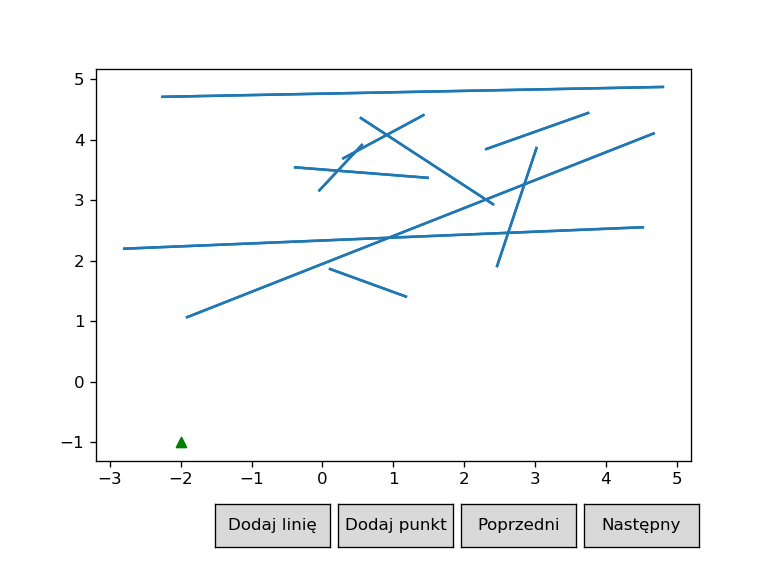

In [16]:
lines = generateRandomLines(10, (-3,1), (5,5))
ordLines = pointsToLineCoord(lines)
# print(ordLines)
scene = Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection(ordLines)]) 
plot3 = Plot([scene])
plot3.draw()

In [17]:

    
            
            
    
sweeping(lines)
        

SortedSet([(-2.8158310680195804, 2.19768114388659), (-2.277450569825878, 4.705227390472125), (-1.9271420557018493, 1.060235779958278), (-0.4036435211433682, 3.5428754019942397), (-0.05518300175494151, 3.1458010064254114), (0.09133885146380916, 1.8701830937608794), (0.2804303164175632, 3.681419423100571), (0.5284429401594597, 4.365929696457851), (0.5680709689188044, 3.92557607716721), (1.1948046823454481, 1.4010635131557625), (1.4414782147527525, 4.412498858472168), (1.5027503684347145, 3.3673676958930225), (2.2970514067867054, 3.8367722694024624), (2.4237823078133225, 2.9214289162517297), (2.4606485371985247, 1.893054458218446), (3.0277410924289745, 3.8786478556923476), (3.7681086688486376, 4.445748205121877), (4.542261729169305, 2.553341754357296), (4.691588766439421, 4.1078846666724065), (4.825384033744114, 4.868987069597694)])
 x =  -2.8158310680195804
adding line
 x =  -2.277450569825878
adding line
 x =  -1.9271420557018493
adding line
 new intersection ---------
 x =  -0.40364352

In [18]:
# intersection tests
    
# tests
pa = Point((0, 0), True, False)
pb = Point((2, 2))
pa.add_other(pb)

pc = Point((-3, 1), True, False)
pd = Point((5, 1))
pc.add_other(pd)

print(intersect(pa, pc))

((1.0, 1.0)) key 1.0 
